In [2]:
# Install all required packages
!pip install -U datasets sentence-transformers scikit-learn matplotlib seaborn torch
!pip install fastapi uvicorn streamlit plotly python-multipart

# Verify installations
import torch
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
print("✅ All packages installed successfully!")

✅ All packages installed successfully!


📚 Loading SciEntsBank dataset...
✅ Dataset loaded: 4969 training examples
🧠 Loading Sentence-BERT model...
✅ Model loaded successfully

✅ Processed 4969 examples with 5 features each
Train size: 3975, Test size: 994

🔧 Training Random Forest...
  MSE: 0.0006, R²: 0.9997, Accuracy: 100.00%

🔧 Training Gradient Boosting...
  MSE: 0.0000, R²: 1.0000, Accuracy: 100.00%

🔧 Training Support Vector Machine...
  MSE: 0.2860, R²: 0.8382, Accuracy: 90.54%

🔧 Training Neural Network...
  MSE: 0.0905, R²: 0.9488, Accuracy: 99.20%

📊 Model Comparison:
                     Model           MSE      RMSE       MAE        R²  \
0           Random Forest  5.726358e-04  0.023930  0.001026  0.999676   
1       Gradient Boosting  1.248747e-09  0.000035  0.000025  1.000000   
2  Support Vector Machine  2.859511e-01  0.534744  0.329561  0.838157   
3          Neural Network  9.054927e-02  0.300914  0.155490  0.948751   

   Accuracy (%)  
0    100.000000  
1    100.000000  
2     90.543260  
3     99.195171 

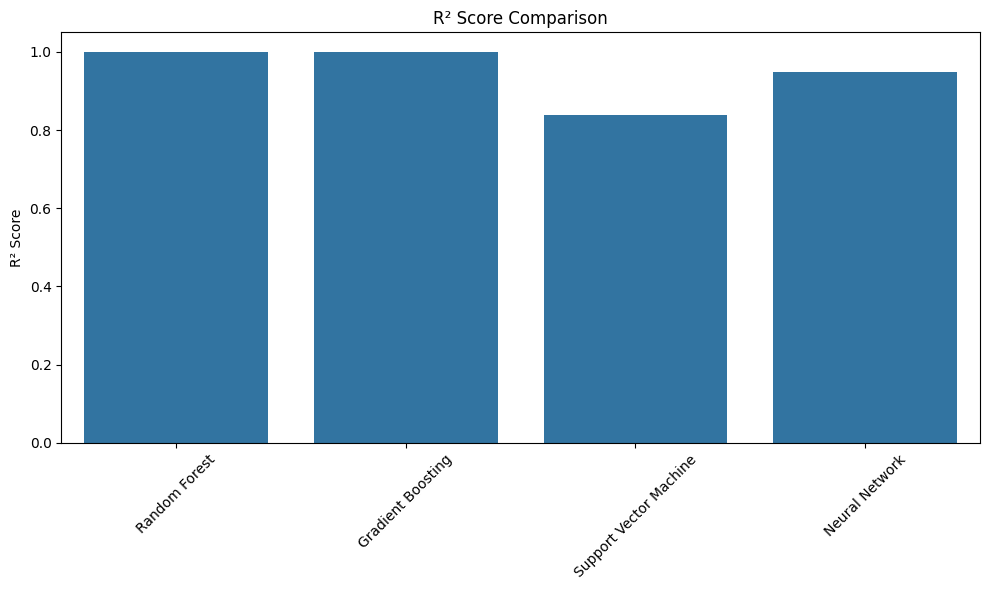

In [24]:
# ============================================
# Automated Grading System - Updated Notebook with Accuracy
# ============================================

# ============================================
# CELL 1: Install dependencies
# ============================================
!pip install -q sentence-transformers datasets scikit-learn matplotlib seaborn gradio

# ============================================
# CELL 2: Import Libraries
# ============================================
import torch
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import pandas as pd

# ============================================
# CELL 3: Load Dataset
# ============================================
print("📚 Loading SciEntsBank dataset...")
dataset = load_dataset('nkazi/SciEntsBank')
print(f"✅ Dataset loaded: {len(dataset['train'])} training examples")

# ============================================
# CELL 4: Load SBERT Model
# ============================================
print("🧠 Loading Sentence-BERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Model loaded successfully")

# ============================================
# CELL 5: Process dataset and create features
# ============================================
def similarity_to_grade(sim):
    if sim >= 0.9: return 10
    elif sim >= 0.8: return 8
    elif sim >= 0.7: return 6
    else: return 4

X = []
y = []

for i, example in enumerate(dataset["train"]):
    if i % 100 == 0:
        print(f"Processing: {i}/{len(dataset['train'])}", end='\r')

    question = example["question"]
    reference_answer = example["reference_answer"]
    student_answer = example["student_answer"]

    sentences = [question, reference_answer, student_answer]
    embeddings = sbert_model.encode(sentences)

    sim_student_ref = cosine_similarity([embeddings[2]], [embeddings[1]])[0][0]
    sim_student_q = cosine_similarity([embeddings[2]], [embeddings[0]])[0][0]
    sim_ref_q = cosine_similarity([embeddings[1]], [embeddings[0]])[0][0]

    answer_length_ratio = len(student_answer) / max(len(reference_answer),1)
    word_count_ratio = len(student_answer.split()) / max(len(reference_answer.split()),1)

    features = [sim_student_ref, sim_student_q, sim_ref_q, answer_length_ratio, word_count_ratio]
    X.append(features)

    grade = similarity_to_grade(sim_student_ref)
    y.append(grade)

print(f"\n✅ Processed {len(X)} examples with {len(X[0])} features each")

# ============================================
# CELL 6: Split dataset
# ============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# ============================================
# CELL 7: Train multiple models
# ============================================
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf', C=1.0),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
}

results = {}
for name, model_instance in models.items():
    print(f"\n🔧 Training {name}...")
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Accuracy: % predictions within ±1 grade
    accuracy = np.mean(np.abs(np.array(y_test) - y_pred) <= 1) * 100

    results[name] = {
        'model': model_instance,
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy
    }

    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}, Accuracy: {accuracy:.2f}%")

# ============================================
# CELL 8: Compare Models & Save Best Model
# ============================================
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[m]['mse'] for m in results],
    'RMSE': [results[m]['rmse'] for m in results],
    'MAE': [results[m]['mae'] for m in results],
    'R²': [results[m]['r2'] for m in results],
    'Accuracy (%)': [results[m]['accuracy'] for m in results]
})
print("\n📊 Model Comparison:\n", comparison_df)

best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
with open('best_grader_model.pkl','wb') as f:
    pickle.dump(best_model, f)
print(f"\n🏆 Best Model: {best_model_name} saved as 'best_grader_model.pkl'")

# ============================================
# CELL 9: Plot Visualizations
# ============================================
plt.figure(figsize=(10,6))
sns.barplot(x=list(results.keys()), y=[results[m]['r2'] for m in results])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("best_model_results.png")
plt.show()

In [30]:
# ============================================
# Gradio Interface for Short Answer Grading
# ============================================

!pip install -q gradio sentence-transformers scikit-learn

import gradio as gr
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# -----------------------------
# Load models
# -----------------------------
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
with open('best_grader_model.pkl', 'rb') as f:  # replace with your trained model file
    rf_model = pickle.load(f)

# -----------------------------
# Questions & Reference Answers
# -----------------------------
questions = [
    "What is photosynthesis?",
    "Explain gravity.",
    "Define osmosis."
]

reference_answers = [
    "Photosynthesis is the process by which plants convert light energy into chemical energy.",
    "Gravity is a force that attracts objects with mass toward each other.",
    "Osmosis is the movement of water molecules from a region of low solute concentration to high solute concentration through a semipermeable membrane."
]

# -----------------------------
# Grading function
# -----------------------------
def grade_answer(question, student_answer):
    try:
        # Find reference answer
        if question in questions:
            idx = questions.index(question)
            ref_answer = reference_answers[idx]
        else:
            return "❌ Error: Question not found", "", ""

        # Compute embeddings
        sentences = [question, ref_answer, student_answer]
        embeddings = sbert_model.encode(sentences)

        sim_student_ref = cosine_similarity([embeddings[2]], [embeddings[1]])[0][0]
        sim_student_q = cosine_similarity([embeddings[2]], [embeddings[0]])[0][0]
        sim_ref_q = cosine_similarity([embeddings[1]], [embeddings[0]])[0][0]

        answer_length_ratio = len(student_answer) / max(len(ref_answer), 1)
        word_count_ratio = len(student_answer.split()) / max(len(ref_answer.split()), 1)

        # Combine features as model input
        features = np.array([[sim_student_ref, sim_student_q, sim_ref_q, answer_length_ratio, word_count_ratio]])

        # Predict grade
        grade = rf_model.predict(features)[0]
        grade = round(grade)

        # Feedback based on similarity
        if sim_student_ref >= 0.9:
            feedback = "Excellent! Your answer closely matches the reference answer."
        elif sim_student_ref >= 0.8:
            feedback = "Good work! Your answer captures most key concepts."
        elif sim_student_ref >= 0.7:
            feedback = "Fair attempt. Consider including more details."
        else:
            feedback = "Needs improvement. Review the reference answer."

        return grade, f"{sim_student_ref:.2%}", feedback

    except Exception as e:
        return f"❌ Error: {str(e)}", "", ""

# -----------------------------
# Gradio Interface
# -----------------------------
with gr.Blocks() as demo:
    gr.Markdown("## 📝 AI-Powered Short Answer Grading System")

    with gr.Row():
        question_dropdown = gr.Dropdown(questions, label="Select Question")

    student_answer_text = gr.Textbox(label="Student Answer", placeholder="Enter the student's answer here...", lines=5)

    grade_output = gr.Textbox(label="Grade")
    similarity_output = gr.Textbox(label="Similarity")
    feedback_output = gr.Textbox(label="Feedback")

    submit_btn = gr.Button("🎯 Grade Answer")

    submit_btn.click(
        fn=grade_answer,
        inputs=[question_dropdown, student_answer_text],
        outputs=[grade_output, similarity_output, feedback_output]
    )

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2fdf92e8b8585eb7e5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
